# Mental Health Treatment Prediction 
**Project Goal:** The objective of this project is to analyze a dataset on mental health in the tech workplace and build a predictive model to determine whether an individual is likely to seek treatment for a mental health condition.  
**Target Variable:** `treatment`

## 1. Importing Libraries

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import(
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

# Set plot style for better aesthetics
sns.set_style('whitegrid')

## 2. Data Loading and Initial Exploration

In [5]:
#Load the dataset
df = pd.read_csv('Mental Health Dataset.csv')
#Display the first 5 rows of the dataset
df.head()

,Timestamp,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
0,8/27/2014 11:29,Female,United States,Corporate,NaN,No,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Not sure
1,8/27/2014 11:31,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,No
2,8/27/2014 11:32,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes
3,8/27/2014 11:37,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,Maybe,Yes
4,8/27/2014 11:43,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes


In [6]:
#Get a summary of the DataFrame, including data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292364 entries, 0 to 292363
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   Timestamp                292364 non-null  object
 1   Gender                   292364 non-null  object
 2   Country                  292364 non-null  object
 3   Occupation               292364 non-null  object
 4   self_employed            287162 non-null  object
 5   family_history           292364 non-null  object
 6   treatment                292364 non-null  object
 7   Days_Indoors             292364 non-null  object
 8   Growing_Stress           292364 non-null  object
 9   Changes_Habits           292364 non-null  object
 10  Mental_Health_History    292364 non-null  object
 11  Mood_Swings              292364 non-null  object
 12  Coping_Struggles         292364 non-null  object
 13  Work_Interest            292364 non-null  object
 14  Social_Weakness     

In [7]:
#Get descriptive statistics for the object columns
df.describe(include='object')

,Timestamp,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
count,292364,292364,292364,292364,287162,292364,292364,292364,292364,292364,292364,292364,292364,292364,292364,292364,292364
unique,580,2,35,5,2,2,2,5,3,3,3,3,2,3,3,3,3
top,8/27/2014 11:43,Male,United States,Housewife,No,No,Yes,1-14 days,Maybe,Yes,No,Medium,No,No,Maybe,No,No
freq,2384,239850,171308,66351,257994,176832,147606,63548,99985,109523,104018,101064,154328,105843,103393,232166,118886


## 3. Data Preprocessing and Cleaning

In [9]:
# Check for and handle duplicate rows
print(f"Number of duplicate rows: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)
print(f"Number of duplicates after dropping: {df.duplicated().sum()}")

# Handle missing values in 'self_employed' by filling with the mode (most frequent value)
mode = df['self_employed'].mode()[0]
df['self_employed'].fillna(mode, inplace=True)

# Drop the Timestamp column as it's not needed for this analysis
df.drop('Timestamp', axis=1, inplace=True)

# Simplify the problem by focusing on data from the United States, as it's the vast majority
df = df[df['Country'] == 'United States']
df.drop('Country', axis=1, inplace=True)

# Reset the index after filtering to maintain a clean DataFrame (0 to N-1)
df.reset_index(drop=True, inplace=True)

# Convert object columns to the more memory-efficient 'category' data type
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category')

print("Preprocessing complete. Updated DataFrame info:\n")
df.info()

Number of duplicate rows: 2313
Number of duplicates after dropping: 0
Preprocessing complete. Updated DataFrame info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169112 entries, 0 to 169111
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   Gender                   169112 non-null  category
 1   Occupation               169112 non-null  category
 2   self_employed            169112 non-null  category
 3   family_history           169112 non-null  category
 4   treatment                169112 non-null  category
 5   Days_Indoors             169112 non-null  category
 6   Growing_Stress           169112 non-null  category
 7   Changes_Habits           169112 non-null  category
 8   Mental_Health_History    169112 non-null  category
 9   Mood_Swings              169112 non-null  category
 10  Coping_Struggles         169112 non-null  category
 11  Work_Interest            169112 non-n

## 4. Exploratory Data Analysis (EDA)

### 4.1. Target Variable Distribution
First, let's examine the distribution of our target variable, `treatment`, to see if the classes are balanced.

C:\Users\radhi\AppData\Local\Temp\ipykernel_17332\670474715.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='treatment', data=df, palette='viridis')


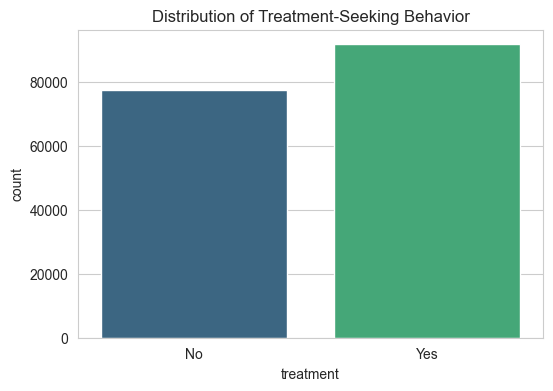

In [12]:
plt.figure(figsize=(6, 4))
sns.countplot(x='treatment', data=df, palette='viridis')
plt.title('Distribution of Treatment-Seeking Behavior')
plt.show()

### 4.2 Label Encoding and Creating Symptom Score

In [14]:
#Create a copy of the dataframe for encoding 
df_encoded = df.copy()

#Create a dictionary to store the label encoders for later use
encoders={}

# Loop through the columns and apply LabelEncoder to category types
for col in df_encoded.select_dtypes(include='category').columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    encoders[col] = le # Save the fitted encoder

# Create a list of symptom-related columns
symptom_cols = [
    'Growing_Stress', 'Changes_Habits', 'Mood_Swings',
    'Coping_Struggles', 'Work_Interest', 'Social_Weakness'
]

# Create a new 'Symptom_Score' feature
df_encoded['Symptom_Score'] = df_encoded[symptom_cols].sum(axis=1)

### 4.3. Correlation Heatmap  
To understand the relationships between all variables, we'll encode them numerically and create a correlation heatmap.

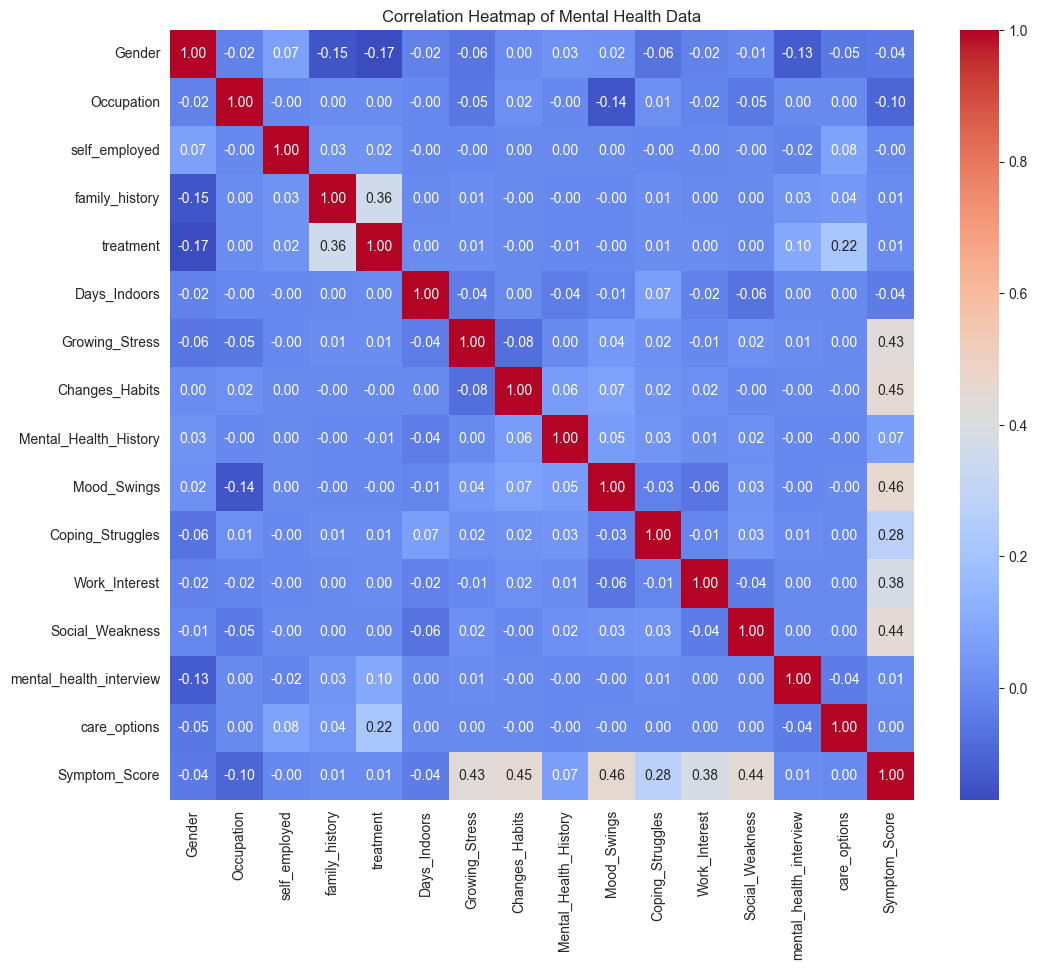

In [16]:
# Create the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Mental Health Data')
plt.show()

## 5. Model Building and Evaluation

In [21]:
# Define features (X) and target (y) from the encoded DataFrame
X = df_encoded.drop('treatment', axis=1)
y = df_encoded['treatment']

# Split the data into training and testing sets (80% train, 20% test)
# 'stratify=y' ensures the same proportion of target classes in both sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### 5.1. Initial Model Comparison
Performs classification using cross-validation, evaluates different models, and makes predictions for each model on the test set.

In [23]:
#Performs classification using cross-validation, evaluates different models, and makes predictions for each model on the test set.
def pipeline_classification(pipelines, X_train, y_train, X_test):
    
    cv_results = []
    model_names = []
    model_predictions = {}

    #cross-validation and storing results
    for name, pipe in pipelines:
        pipe.fit(X_train, y_train)
        kfold = KFold(n_splits = 10, shuffle = True, random_state=42)
        cv_results.append(cross_val_score(pipe, X_train, y_train, cv = kfold, scoring = 'accuracy', n_jobs = -1))
        model_names.append(name)
        model_predictions[name] = pipe.predict(X_test)

    plt.figure(figsize=(8, 6))
    plt.boxplot(cv_results)
    plt.xticks(range(1, len(model_names) + 1), model_names)
    plt.title('Algorithm Comparison')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.show()

    results_df = pd.DataFrame({
      'Model': model_names,
      'Mean Accuracy': [scores.mean() for scores in cv_results],
      'Standard Deviation': [scores.std() for scores in cv_results]
    })

    return results_df, model_predictions

[LightGBM] [Info] Number of positive: 73350, number of negative: 61939
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 54
[LightGBM] [Info] Number of data points in the train set: 135289, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542173 -> initscore=0.169092
[LightGBM] [Info] Start training from score 0.169092


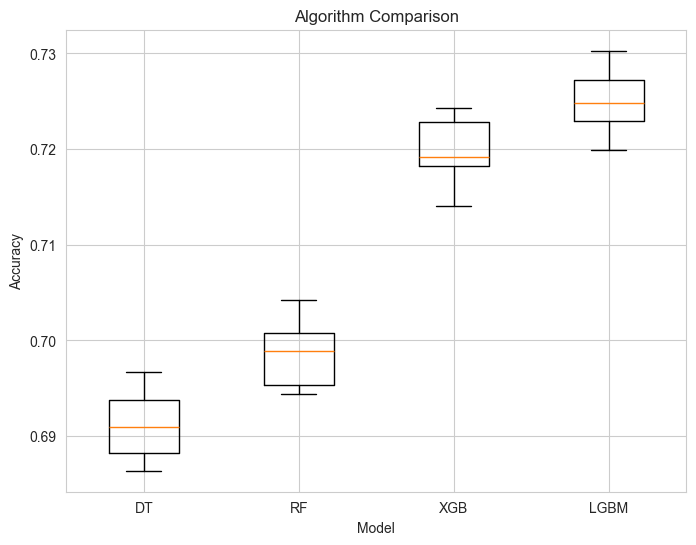

---Model Comparison Results---
  Model  Mean Accuracy  Standard Deviation
0    DT       0.690928            0.003386
1    RF       0.698542            0.003270
2   XGB       0.719859            0.003126
3  LGBM       0.725233            0.003174
\n==================================================\n


In [24]:
pipelines = [
    ('DT', Pipeline([('scaler', MinMaxScaler()), ('DT', DecisionTreeClassifier(random_state=42))])),
    ('RF', Pipeline([('scaler', MinMaxScaler()), ('RF', RandomForestClassifier(random_state=42))])),
    ('XGB', Pipeline([('XGB', XGBClassifier(random_state=42))])),
    ('LGBM', Pipeline([('LGBM', LGBMClassifier(random_state=42))]))
]

results_df, model_predictions = pipeline_classification(pipelines, X_train, y_train, X_test)
print('---Model Comparison Results---')
print(results_df)
print("\\n" + "="*50 + "\\n")

### 5.2. Hyperparameter Tuning for XGBoost
Based on the initial comparison, XGBoost performed the best. Now, we'll tune its hyperparameters.

Best Parameters: {'num_leaves': 20, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.01}
\nTuned LightGBM Model Accuracy: 0.73
\nClassification Report for Tuned LightGBM:
              precision    recall  f1-score   support

No Treatment       0.78      0.58      0.66     15485
   Treatment       0.71      0.86      0.78     18338

    accuracy                           0.73     33823
   macro avg       0.74      0.72      0.72     33823
weighted avg       0.74      0.73      0.73     33823



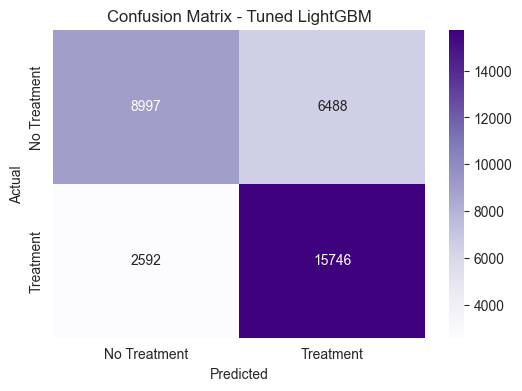

In [29]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 40]
}
lgbm = LGBMClassifier(random_state=42, verbosity=-1)
random_search = RandomizedSearchCV(estimator=lgbm, param_distributions=param_dist, n_iter=50, cv=5, n_jobs=-1, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)
best_lgbm_model = random_search.best_estimator_

print(f"Best Parameters: {random_search.best_params_}")
tuned_lgbm_pred = best_lgbm_model.predict(X_test)

print(f"\\nTuned LightGBM Model Accuracy: {accuracy_score(y_test, tuned_lgbm_pred):.2f}")
print("\\nClassification Report for Tuned LightGBM:")
print(classification_report(y_test, tuned_lgbm_pred, target_names=['No Treatment', 'Treatment']))

cm = confusion_matrix(y_test, tuned_lgbm_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['No Treatment', 'Treatment'], yticklabels=['No Treatment', 'Treatment'])
plt.title('Confusion Matrix - Tuned LightGBM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 6. Feature Importance (Tuned LightGBM)

---Plotting Feature Importance---


C:\Users\radhi\AppData\Local\Temp\ipykernel_17332\2173649442.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


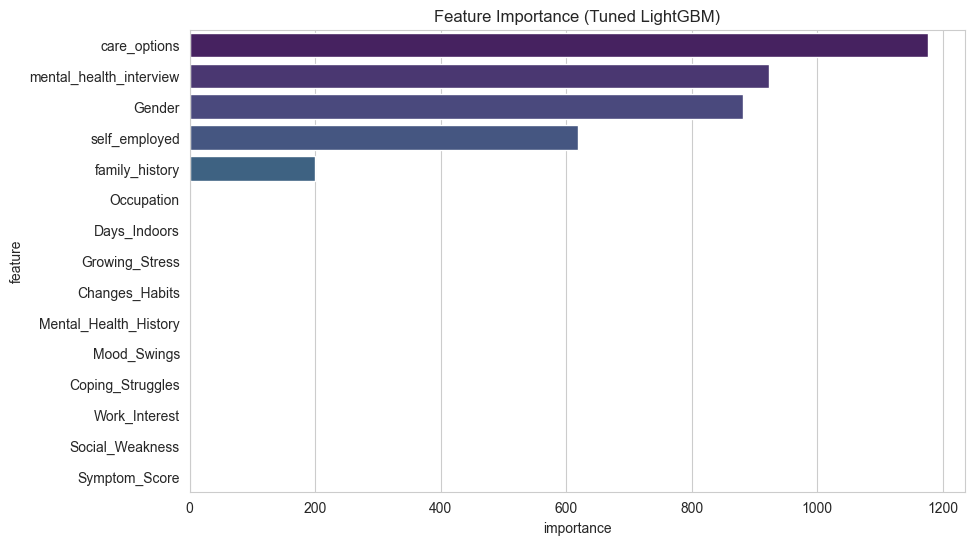

In [34]:
print("---Plotting Feature Importance---")
importances = best_lgbm_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance (Tuned LightGBM)')
plt.show()

## 7. Save Final Model and Encoders for Streamlit App

In [44]:
print("--- Saving Final Model and Encoders ---")
# Save the best model
with open('best_lgbm_model.pkl', 'wb') as f:
    pickle.dump(best_lgbm_model, f)

# Save the encoders
with open('encoders.pkl', 'wb') as f:
    pickle.dump(encoders, f)

# Save the training columns to ensure order is the same for prediction
with open('training_columns.pkl', 'wb') as f:
    pickle.dump(X_train.columns.tolist(), f)

print("Model, encoders, and training columns saved successfully.")
print("\\n" + "="*50 + "\\n")

--- Saving Final Model and Encoders ---
Model, encoders, and training columns saved successfully.
\n==================================================\n
